In [12]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

plt.style.use("seaborn-v0_8")


# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-3, 3, N)
    Y = X + 1
    Y += sigma_obs * np.random.randn(N)
    return X, Y


X, Y = get_data(N=30)

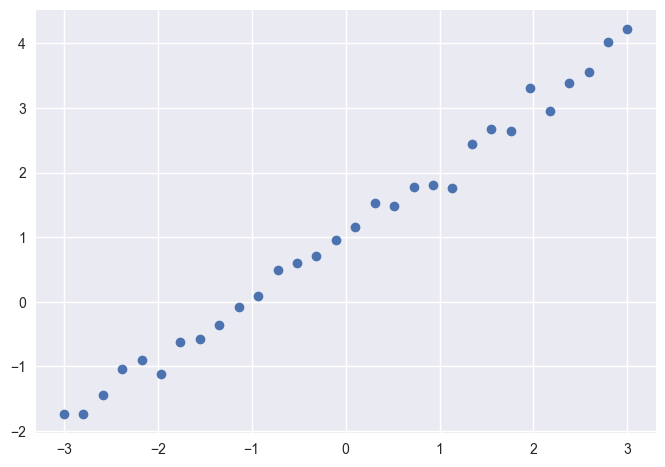

In [13]:
plt.plot(X, Y, "o")
plt.show()

In [20]:
# Write the code for Gaussian Process regression.
# Feel free to copy the code from the lecture note.


In [16]:
X_test = jnp.linspace(-3, 10, 400)

def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

rng_key, rng_key_ = random.split(rng_key)
keys = random.split(rng_key_, samples["kernel_var"].shape[0])
vars = samples["kernel_var"]
lengths = samples["kernel_length"]
noises = samples["kernel_noise"]

means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(keys, vars, lengths, noises)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

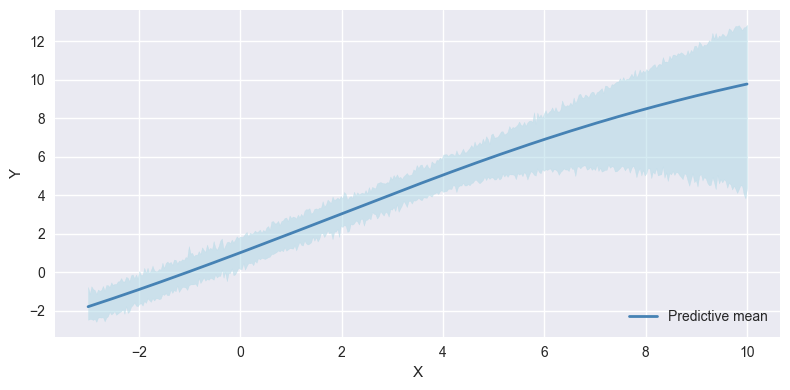

In [19]:
# Plot the result
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))


ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.5)
ax.plot(X_test, mean_prediction, c="steelblue", ls="solid", lw=2.0, label="Predictive mean")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()